# This notebooks aims to answer the set of questions below based on the Kings County Housing dataset:
    - What are the top 5 - 6 features that are the most important in determining a house price
    - How much in average is the price difference between waterfront houses and non-waterfront houses
    - Which zipcode attracts higher prices and vice versa
    - How have average house prices faired over a 12 month period and when is the best time of the year to sell?
    - [TBD] Which matters more, yard space or living space?

#### Import the necesary python packages for data cleaning, manipulation and vizualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format

#### Set a variable 'url' that contains the url for the Kings County House dataset
#### Import the data using the pandas 'read_csv' method and use 'parse_dates' argument to convert the 'date' column from str to datetime

In [2]:
url = 'https://raw.githubusercontent.com/Ftan91/Project-1---Kings-County-House-Dataset/master/kc_house_data.csv'
df = pd.read_csv(url, parse_dates = ['date'])

Check the first 5 rows of the dataframe and get the general information of the dataframe

In [3]:
display (df.head())

df.info()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,"221,900.00",3,1.00,1180,5650,1.00,nan,0.00,...,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,2014-12-09,"538,000.00",3,2.25,2570,7242,2.00,0.00,0.00,...,7,2170,400.0,1951,"1,991.00",98125,47.72,-122.32,1690,7639
2,5631500400,2015-02-25,"180,000.00",2,1.00,770,10000,1.00,0.00,0.00,...,6,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062
3,2487200875,2014-12-09,"604,000.00",4,3.00,1960,5000,1.00,0.00,0.00,...,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2015-02-18,"510,000.00",3,2.00,1680,8080,1.00,0.00,0.00,...,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

Check and drop for duplicates

In [4]:
df = df.drop_duplicates(subset = 'id')
print ('Number of rows before: 21597')
print ('Number of rows after dropping duplicates: {}'.format(df.shape[0]))
print ('Total number of rows dropped: {}'.format(21597 - df.shape[0]))

Number of rows before: 21597
Number of rows after dropping duplicates: 21420
Total number of rows dropped: 177


#### Define functions to clean columns

In [5]:
# define function to return number of unique data types and the list of data types for a single column
def datatype_search(column):
    x = df[column].unique()
    y = set([type(number) for number in x])
    z = len(y)
    return list(y), z

# define function to return a random number based on given list of choice, added with probability
def function(column):
    if column == 'sqft_basement':
        basement_unique = df[df['sqft_basement'] != '?']['sqft_basement'].unique()
        basement_prob = df[df['sqft_basement'] != '?']['sqft_basement'].value_counts(normalize = True)
        return np.random.choice(basement_unique, 1, p= basement_prob)[0]
    else:
        unique = df[df[column].notnull()][column].unique()
        prob = df[df[column].notnull()][column].value_counts(normalize = True)
        return np.random.choice(unique, 1, p= prob)[0]
    
def year_value(row):
    if row["yr_renovated"] == 0.0 or pd.isna(row["yr_renovated"]) == True:
        return row["yr_built"]
    else:
        return row["yr_renovated"]
    
def data_quality_summary(data):
    dictionary = {'Feature': [],
                 'Null Entries': [],
                 'No. of unique datatype(s)' : [],
                 'Feature datatype(s)' : [],
                 'Min, Max': []
                 }
    
    for column in data.columns:
        dictionary['Feature'].append(column)
        dictionary['Null Entries'].append(data[column].isnull().sum())
        dictionary['No. of unique datatype(s)'].append(datatype_search(column)[1])
        dictionary['Feature datatype(s)'].append(datatype_search(column)[0])
        dictionary['Min, Max'].append((data[column].min(), data[column].max()))
        
    summary = pd.DataFrame(dictionary)
    return summary

Print general description of each column including missing values, number of data entries for each column, negati

In [6]:
print ('BASIC DATA QUALITY CHECK: ')
data_quality_summary(df)

BASIC DATA QUALITY CHECK: 


,Feature,Null Entries,No. of unique datatype(s),Feature datatype(s),"Min, Max"
0,id,0,1,[<class 'numpy.int64'>],"(1000102, 9900000190)"
1,date,0,1,[<class 'numpy.datetime64'>],"(2014-05-02 00:00:00, 2015-05-27 00:00:00)"
2,price,0,1,[<class 'numpy.float64'>],"(78000.0, 7700000.0)"
3,bedrooms,0,1,[<class 'numpy.int64'>],"(1, 33)"
4,bathrooms,0,1,[<class 'numpy.float64'>],"(0.5, 8.0)"
5,sqft_living,0,1,[<class 'numpy.int64'>],"(370, 13540)"
6,sqft_lot,0,1,[<class 'numpy.int64'>],"(520, 1651359)"
7,floors,0,1,[<class 'numpy.float64'>],"(1.0, 3.5)"
8,waterfront,2353,1,[<class 'numpy.float64'>],"(0.0, 1.0)"
9,view,63,1,[<class 'numpy.float64'>],"(0.0, 4.0)"


Now we can clearly see some data quality issues here including null entries, wrong datatype and outliers. Let's fix this. Below, let's fill columns with missing values according to column distribution

In [7]:
missing_values_column = ['yr_renovated', 'waterfront', 'view', 'sqft_basement']

for column in missing_values_column:
    df[column] = df[column].map(lambda x: function(column) if (pd.isnull(x) or x == '?') else x)

Next we convert the sqft_basement column into an int64 datatype

In [8]:
df['sqft_basement'] = df['sqft_basement'].map(lambda x: int(float(x)))

Given the number of 'sqft' type columns, it is worth checking if there are any errors

In [9]:
sqft_columns = ['sqft_lot', 'sqft_living', 'sqft_above', 'sqft_basement']
df[sqft_columns].head(5)

,sqft_lot,sqft_living,sqft_above,sqft_basement
0,5650,1180,1180,0
1,7242,2570,2170,400
2,10000,770,770,0
3,5000,1960,1050,910
4,8080,1680,1680,0


Looks like sqft_living is equivalent to the sum of above and basement columns. Let's further sense check if all rows are summed correctly and drop those which are not

In [10]:
to_drop = df[df['sqft_living'] != df['sqft_above'] + df['sqft_basement']].index
df.drop(to_drop, axis = 0, inplace = True)

For clarity, sqft_lot is defined as the sqft_living (above and basement) and all yard (front and back)

In [11]:
to_drop2 = df[sqft_columns][df.sqft_living > df.sqft_lot].index
df.drop(to_drop2, axis = 0, inplace = True)

In [12]:
print ('Latest number of rows: 21420')
print ('Number of rows after dropping above: {}'.format(df.shape[0]))
print ('Total number of rows dropped: {}'.format(21420 - df.shape[0]))

Latest number of rows: 21420
Number of rows after dropping above: 20361
Total number of rows dropped: 1059


Now let's look for any outliers within continous variables

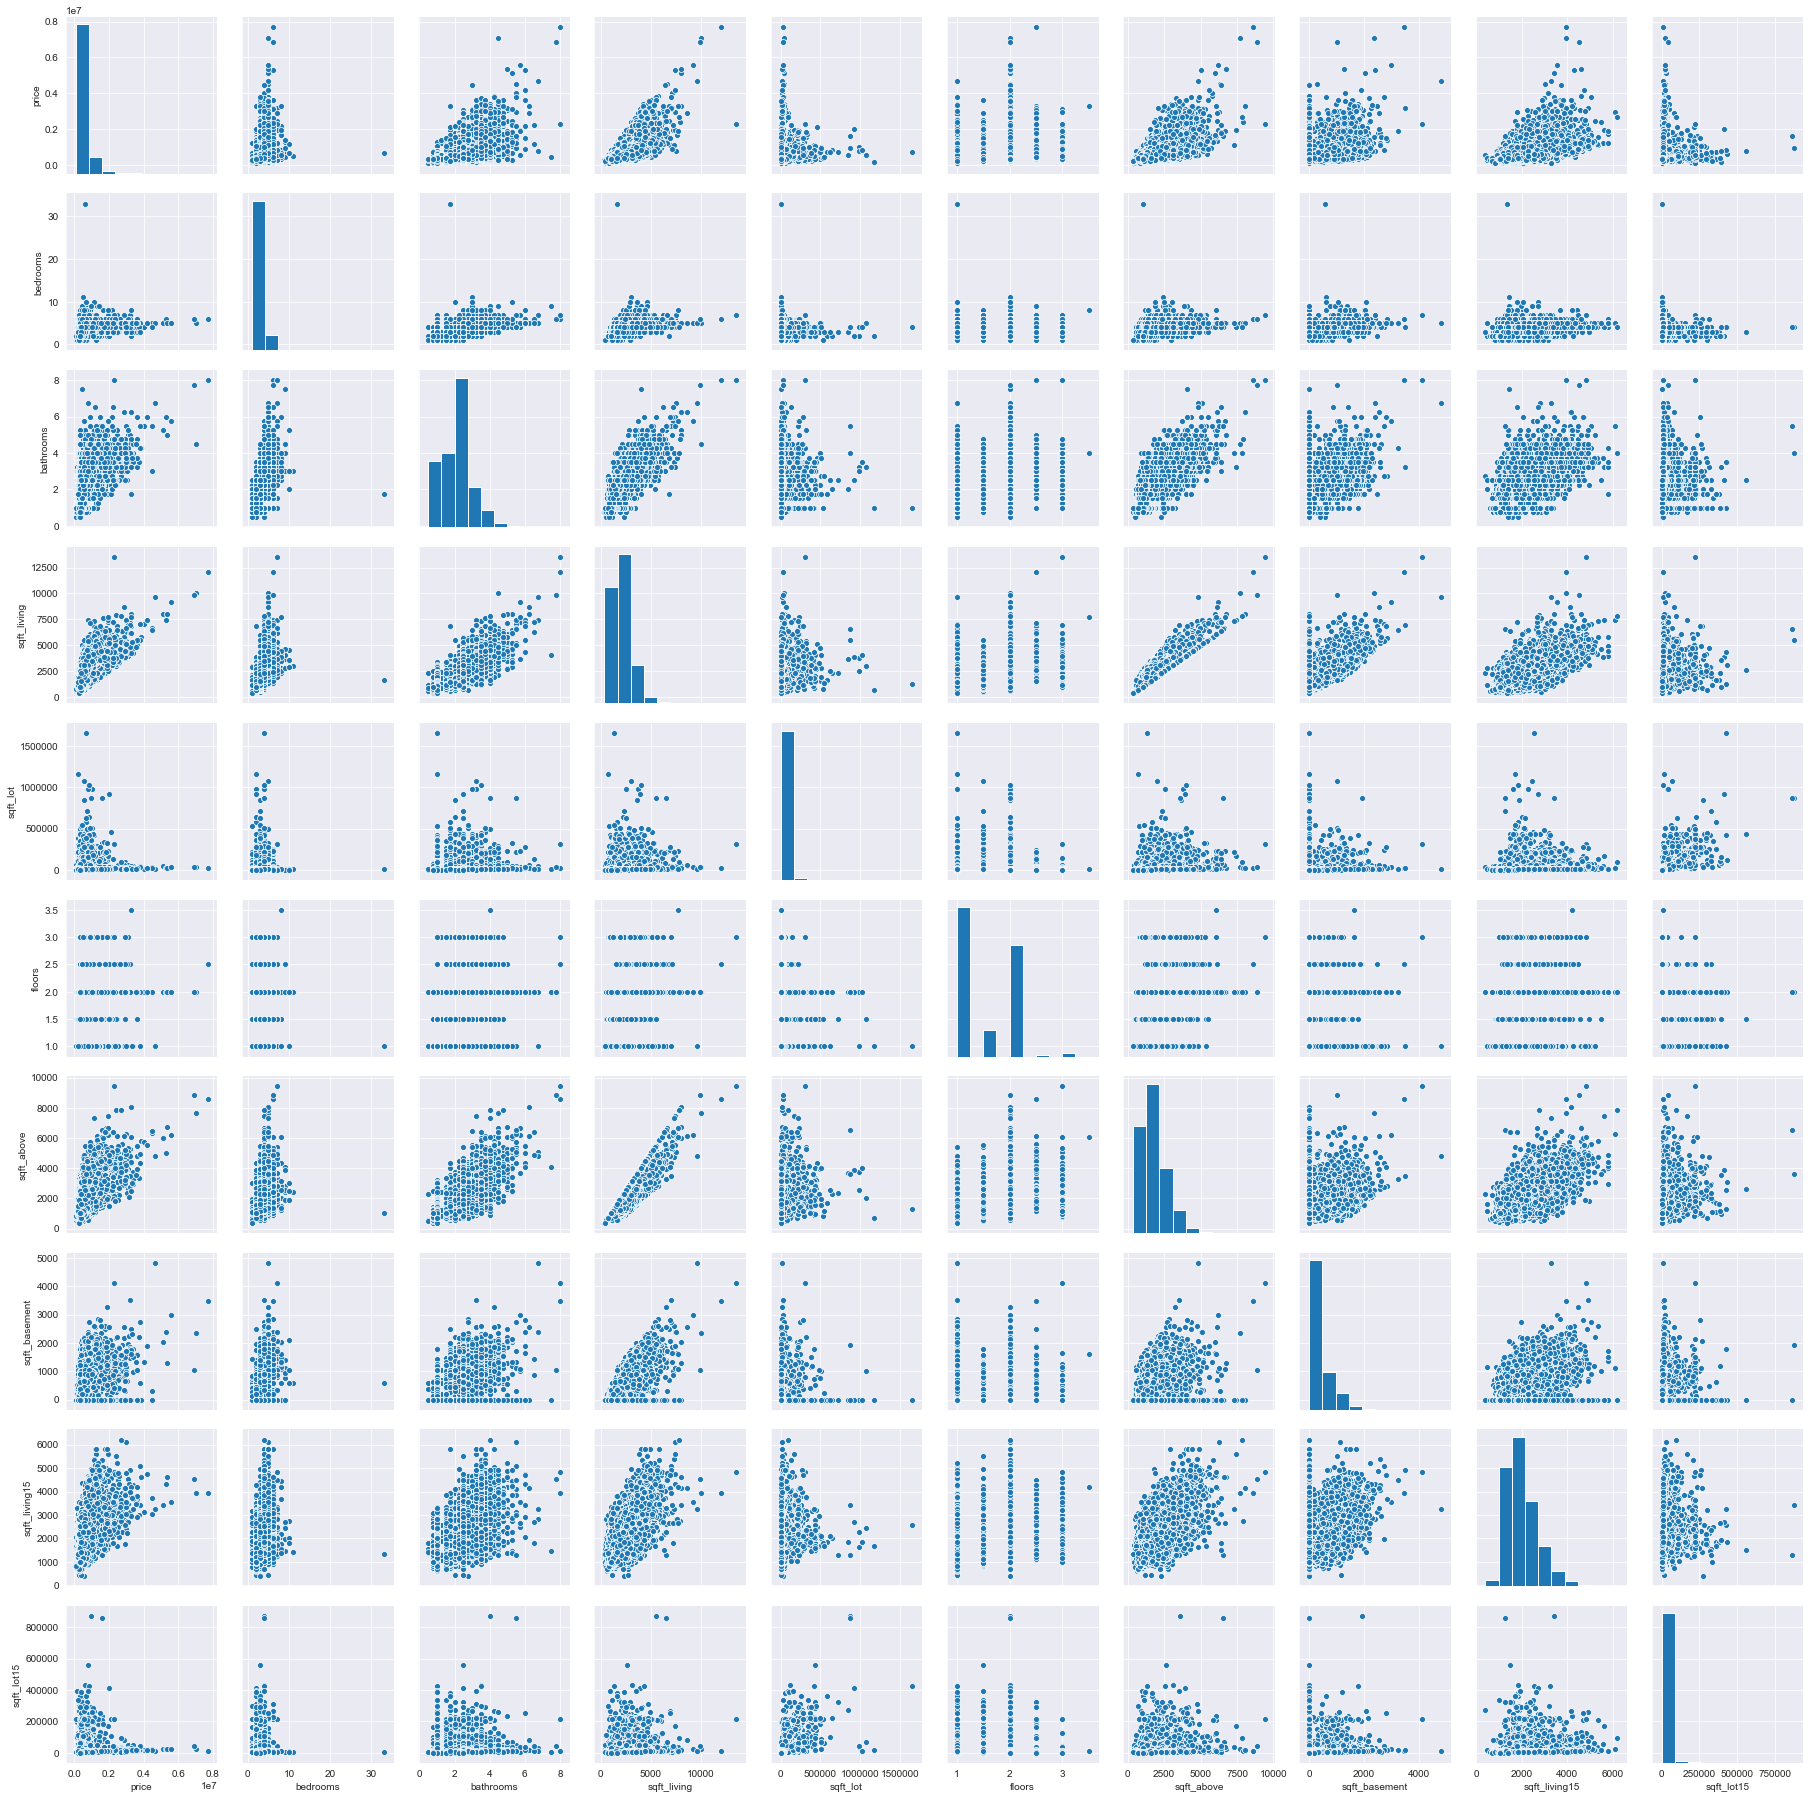

In [13]:
continuous = df.drop(['id','date','zipcode','lat', 'long', 'waterfront', 'view', 'condition', 'grade', 'yr_renovated', 'yr_built'], axis = 1)
sns.pairplot(continuous)
plt.show()

Remove outliers

In [14]:
for column in continuous.columns:
    print (df[column].value_counts(bins = 10, sort = False))
    print ('\n')

(70377.999, 840200.0]     17900
(840200.0, 1602400.0]      2047
(1602400.0, 2364600.0]      288
(2364600.0, 3126800.0]       89
(3126800.0, 3889000.0]       25
(3889000.0, 4651200.0]        4
(4651200.0, 5413400.0]        4
(5413400.0, 6175600.0]        1
(6175600.0, 6937800.0]        1
(6937800.0, 7700000.0]        2
Name: price, dtype: int64


(0.967, 4.2]    18499
(4.2, 7.4]       1839
(7.4, 10.6]        21
(10.6, 13.8]        1
(13.8, 17.0]        0
(17.0, 20.2]        0
(20.2, 23.4]        0
(23.4, 26.6]        0
(26.6, 29.8]        0
(29.8, 33.0]        1
Name: bedrooms, dtype: int64


(0.491, 1.25]    3826
(1.25, 2.0]      6103
(2.0, 2.75]      8030
(2.75, 3.5]      1864
(3.5, 4.25]       360
(4.25, 5.0]       136
(5.0, 5.75]        26
(5.75, 6.5]        10
(6.5, 7.25]         2
(7.25, 8.0]         4
Name: bathrooms, dtype: int64


(356.829, 1687.0]     7589
(1687.0, 3004.0]      9773
(3004.0, 4321.0]      2514
(4321.0, 5638.0]       385
(5638.0, 6955.0]        70
(6955.0, 8272.

In [15]:
df.drop(df[df.bedrooms > 20].index, axis = 0, inplace = True)

Feature Engineering adding possibly new and useful columns

In [16]:
df['year_old'] = df.apply(lambda row: year_value(row), axis=1)
df['house_age'] = 2019 - df['year_old']

## 1. What are the top 5 - 6 actionable features in determining house price?

First, let's take a look at the correlation matrix across variables

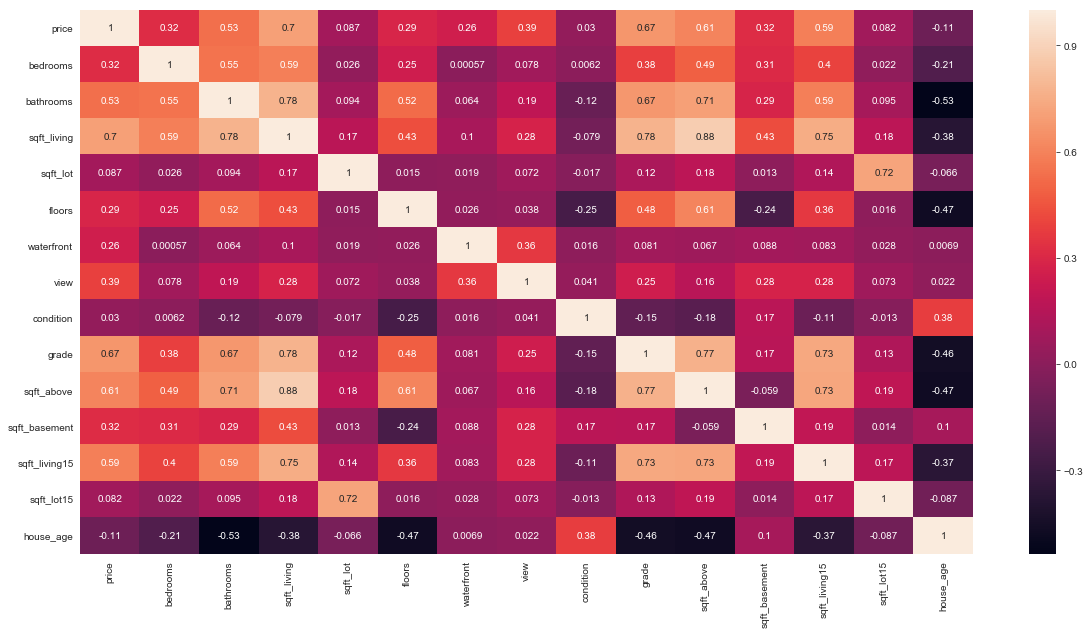

In [17]:
columns_to_drop = ['id', 'date', 'zipcode','lat', 'long', 'yr_built', 'yr_renovated', 'year_old']
new_df = df.drop(columns_to_drop, axis = 1)
correlation_matrix = new_df.corr()

fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(correlation_matrix, annot = True, ax = ax)
plt.show()

Now let's pick out the top 10 actionable variables with the highest correlation to price

In [18]:
x = correlation_matrix['price'].sort_values(ascending = False)
top10_price_correlation = x[:10]
top10_price_correlation

price           1.00
sqft_living     0.70
grade           0.67
sqft_above      0.61
sqft_living15   0.59
bathrooms       0.53
view            0.39
sqft_basement   0.32
bedrooms        0.32
floors          0.29
Name: price, dtype: float64

Given the sum of sqft_above and sqft_below results in sqft_living, both will be ignored. Sqft_living15 will also be removed as this would be difficult for a house buyer/seller to have an impact on this

In [19]:
to_drop = ['price', 'sqft_above', 'sqft_basement', 'sqft_living15']
top6_price_correlation = top10_price_correlation.drop(to_drop, axis = 0)
top6_price_correlation

sqft_living   0.70
grade         0.67
bathrooms     0.53
view          0.39
bedrooms      0.32
floors        0.29
Name: price, dtype: float64

Great! Let's take a look at the scatterplots of price against each selected feature above

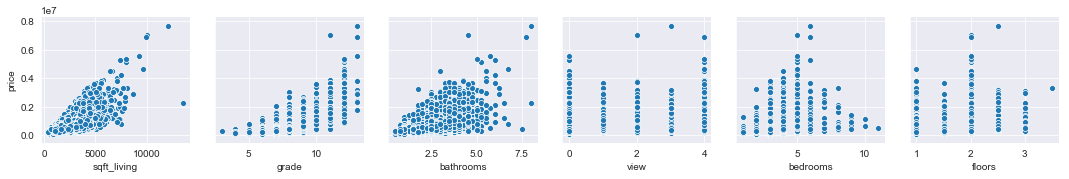

In [20]:
sns.pairplot(data = df, y_vars=['price'], x_vars = top6_price_correlation.index)
plt.show()

Now, let's take a look at the distribution of each of the above features

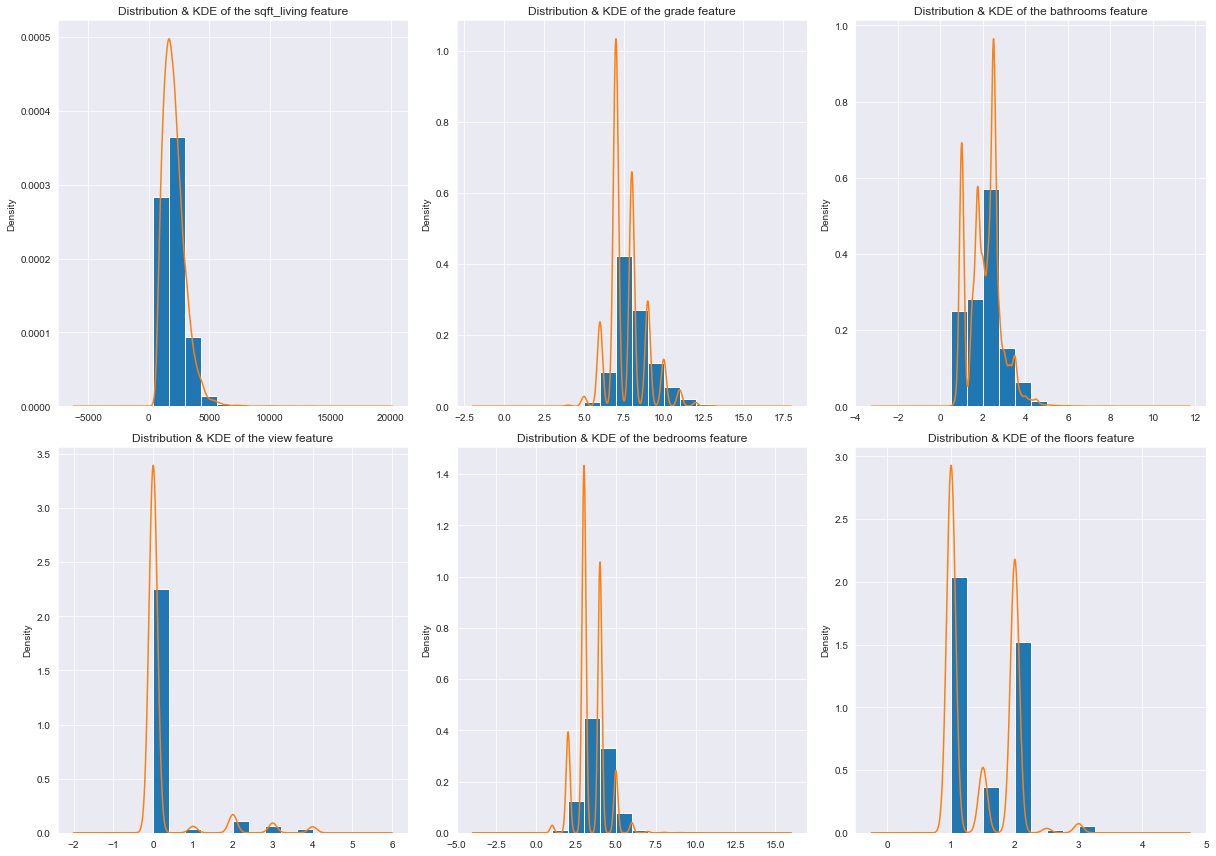

In [21]:
fig, axes = plt.subplots(2, 3, tight_layout = True, figsize = (17,12))
ax = [axes[0, 0], axes[0, 1], axes[0, 2], axes[1, 0], axes[1, 1], axes[1, 2]]

for index in range(len(top6_price_correlation.index)):
    df[top6_price_correlation.index[index]].plot(kind = 'hist', ax = ax[index], normed = True)
    df[top6_price_correlation.index[index]].plot(kind = 'kde', ax = ax[index])
    ax[index].set_title('Distribution & KDE of the {} feature'.format(top6_price_correlation.index[index]))

Kde is better than hist because its not affected by the number of bins

As you can see above, majority of features do not follow a normal distribution however this is not a condition for linear regression (errors need to be normally distributed - this can be done through a QQ plot)

Now that we have identify the top 6 variables, let's dig deeper into how each variable perform in a simple linear regression model.

First, let's define a function to return summary attributes for all selected features

In [22]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols

def OLS_summary(feature_correlations, data, log = False):
    summary = {'feature' : [], 
           'Pearson_r'  : [], 
           'Pearson_r2' : [], 
           'R2' : [], 
           'P_value': [],
           'Coef_value' : [],
           'F_value' : [],
           'T_value' : [],
           'Resid. Skew': [],
           'Resid. Kurtosis': []
          }

    if log == False:    
        for index in range(len(feature_correlations)):
            f = 'price~' + feature_correlations.index[index]
            model = ols(formula = f, data = data).fit()
            summary['feature'].append(feature_correlations.index[index])
            summary['Pearson_r'].append(round(feature_correlations[index],2))
            summary['Pearson_r2'].append(round(feature_correlations[index] ** 2,2))
            summary['R2'].append(round(model.rsquared,2))
            summary['P_value'].append(round(model.pvalues[1],2))
            summary['F_value'].append(round(model.fvalue,2))
            summary['T_value'].append(round(model.tvalues[1],2))
            summary['Resid. Skew'].append(round(sms.jarque_bera(model.resid)[2],2))
            summary['Resid. Kurtosis'].append(round(sms.jarque_bera(model.resid)[-1],2))
            summary['Coef_value'].append(round(model.params[1],2))
        summary_df = pd.DataFrame(summary)
        return summary_df
    else:
        for index in range(len(feature_correlations)):
            f = 'price_log~' + feature_correlations.index[index]
            model = ols(formula = f, data = data).fit()
            summary['feature'].append(feature_correlations.index[index])
            summary['Pearson_r'].append(round(feature_correlations[index],2))
            summary['Pearson_r2'].append(round(feature_correlations[index] ** 2,2))
            summary['R2'].append(round(model.rsquared,2))
            summary['P_value'].append(round(model.pvalues[1],2))
            summary['F_value'].append(round(model.fvalue,2))
            summary['T_value'].append(round(model.tvalues[1],2))
            summary['Resid. Skew'].append(round(sms.jarque_bera(model.resid)[2],2))
            summary['Resid. Kurtosis'].append(round(sms.jarque_bera(model.resid)[-1],2))
            summary['Coef_value'].append(round(model.params[1],2))
        summary_df = pd.DataFrame(summary)
        return summary_df

Now let's put our function to the test 

In [23]:
model = list(top6_price_correlation.index) + ['price']
df_model = df[model]

OLS_summary(top6_price_correlation, df_model, log = False)

,feature,Pearson_r,Pearson_r2,R2,P_value,Coef_value,F_value,T_value,Resid. Skew,Resid. Kurtosis
0,sqft_living,0.70,0.49,0.49,0.00,282.93,"19,946.02",141.23,2.84,26.81
1,grade,0.67,0.45,0.45,0.00,"210,572.05","16,583.07",128.78,4.09,49.92
2,bathrooms,0.53,0.28,0.28,0.00,"257,080.87","8,091.19",89.95,3.44,33.39
3,view,0.39,0.15,0.15,0.00,"189,880.73","3,710.83",60.92,3.64,36.42
4,bedrooms,0.32,0.10,0.10,0.00,"131,217.31","2,296.38",47.92,3.94,38.02
5,floors,0.29,0.08,0.08,0.00,"211,258.65","1,827.60",42.75,4.07,39.66


Let's dig deeper and identify if the effects of log transforming the data. Given the invalid values of log (0), let's remove the 'view' feature for simplicity sake

In [24]:
df_model2 = df_model.drop('view', axis = 1)
df_model_log = np.log(df_model2)
df_model_log.columns = ['sqft_living_log', 'grade_log', 'bathrooms_log', 'bedrooms_log', 'floors_log', 'price_log']
top5_log_corr = df_model_log.corr()['price_log'].drop('price_log', axis = 0).sort_values(ascending = False)

OLS_summary(top5_log_corr, df_model_log, log = True)

,feature,Pearson_r,Pearson_r2,R2,P_value,Coef_value,F_value,T_value,Resid. Skew,Resid. Kurtosis
0,grade_log,0.70,0.48,0.48,0.00,2.46,"19,096.77",138.19,0.20,3.20
1,sqft_living_log,0.68,0.46,0.46,0.00,0.85,"17,382.27",131.84,0.18,2.79
2,bathrooms_log,0.53,0.28,0.28,0.00,0.71,"7,760.48",88.09,0.29,3.07
3,bedrooms_log,0.35,0.12,0.12,0.00,0.66,"2,823.96",53.14,0.37,3.44
4,floors_log,0.34,0.12,0.12,0.00,0.53,"2,673.76",51.71,0.41,3.61


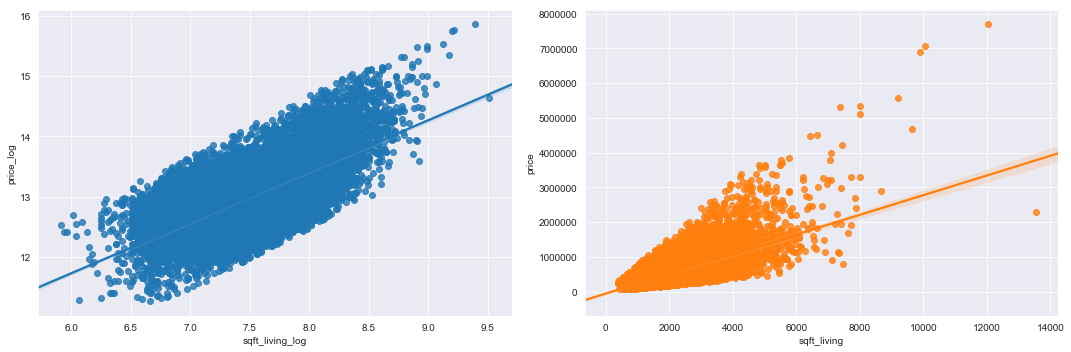

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, tight_layout = True, figsize = (15,5))
sns.regplot(x = 'sqft_living_log', y = 'price_log', data = df_model_log, ci = 100, ax = ax1)
sns.regplot(x = 'sqft_living', y = 'price', data = df_model, ci = 100, ax = ax2)
plt.show()

This now looks like a better model noting the comparabilty of coefficient values and a more normal distribution of errors. 

Outside of this, we can use a multiple regression model but will be outside of this exercise

Why not qq-plot? JB better for larger datasets

## 2. What are the average price difference between waterfront and non-waterfront houses

Let's have a general look at house price which are closer to waterfronts

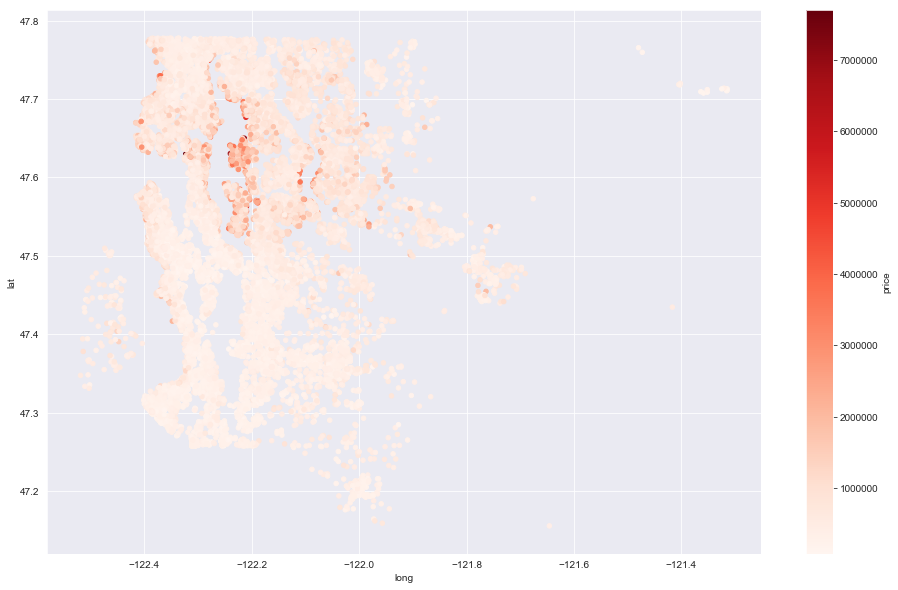

In [26]:
df.plot(kind = 'scatter', 
        x = 'long', 
        y = 'lat', 
        figsize = (16,10), 
        c= 'price', 
        cmap = 'Reds', 
        colorbar = True, 
        sharex = False)
plt.show()

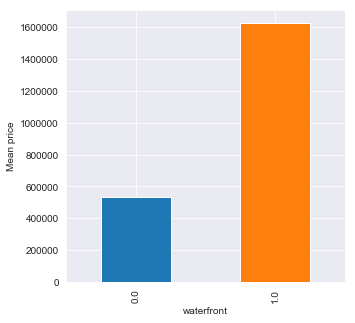

In [27]:
waterfront_general = df.groupby('waterfront')['price'].mean()
waterfront_general.plot.bar(figsize = (5,5))
plt.ylabel('Mean price')
plt.show()

For those interested in buying / selling waterfronts, below are the general differences in price based on the first 6 main features identified earlier

In [28]:
df['binned_sqft_living'] = pd.qcut(df['sqft_living'], q=10)

top6_price_correlation_list = top6_price_correlation.index.tolist()
final = ['binned_sqft_living'] + top6_price_correlation_list
del final[1]

groupby_list = []
for feature in final:
    groupby_list.append(df.groupby(['waterfront', feature])['price'].mean().reset_index())

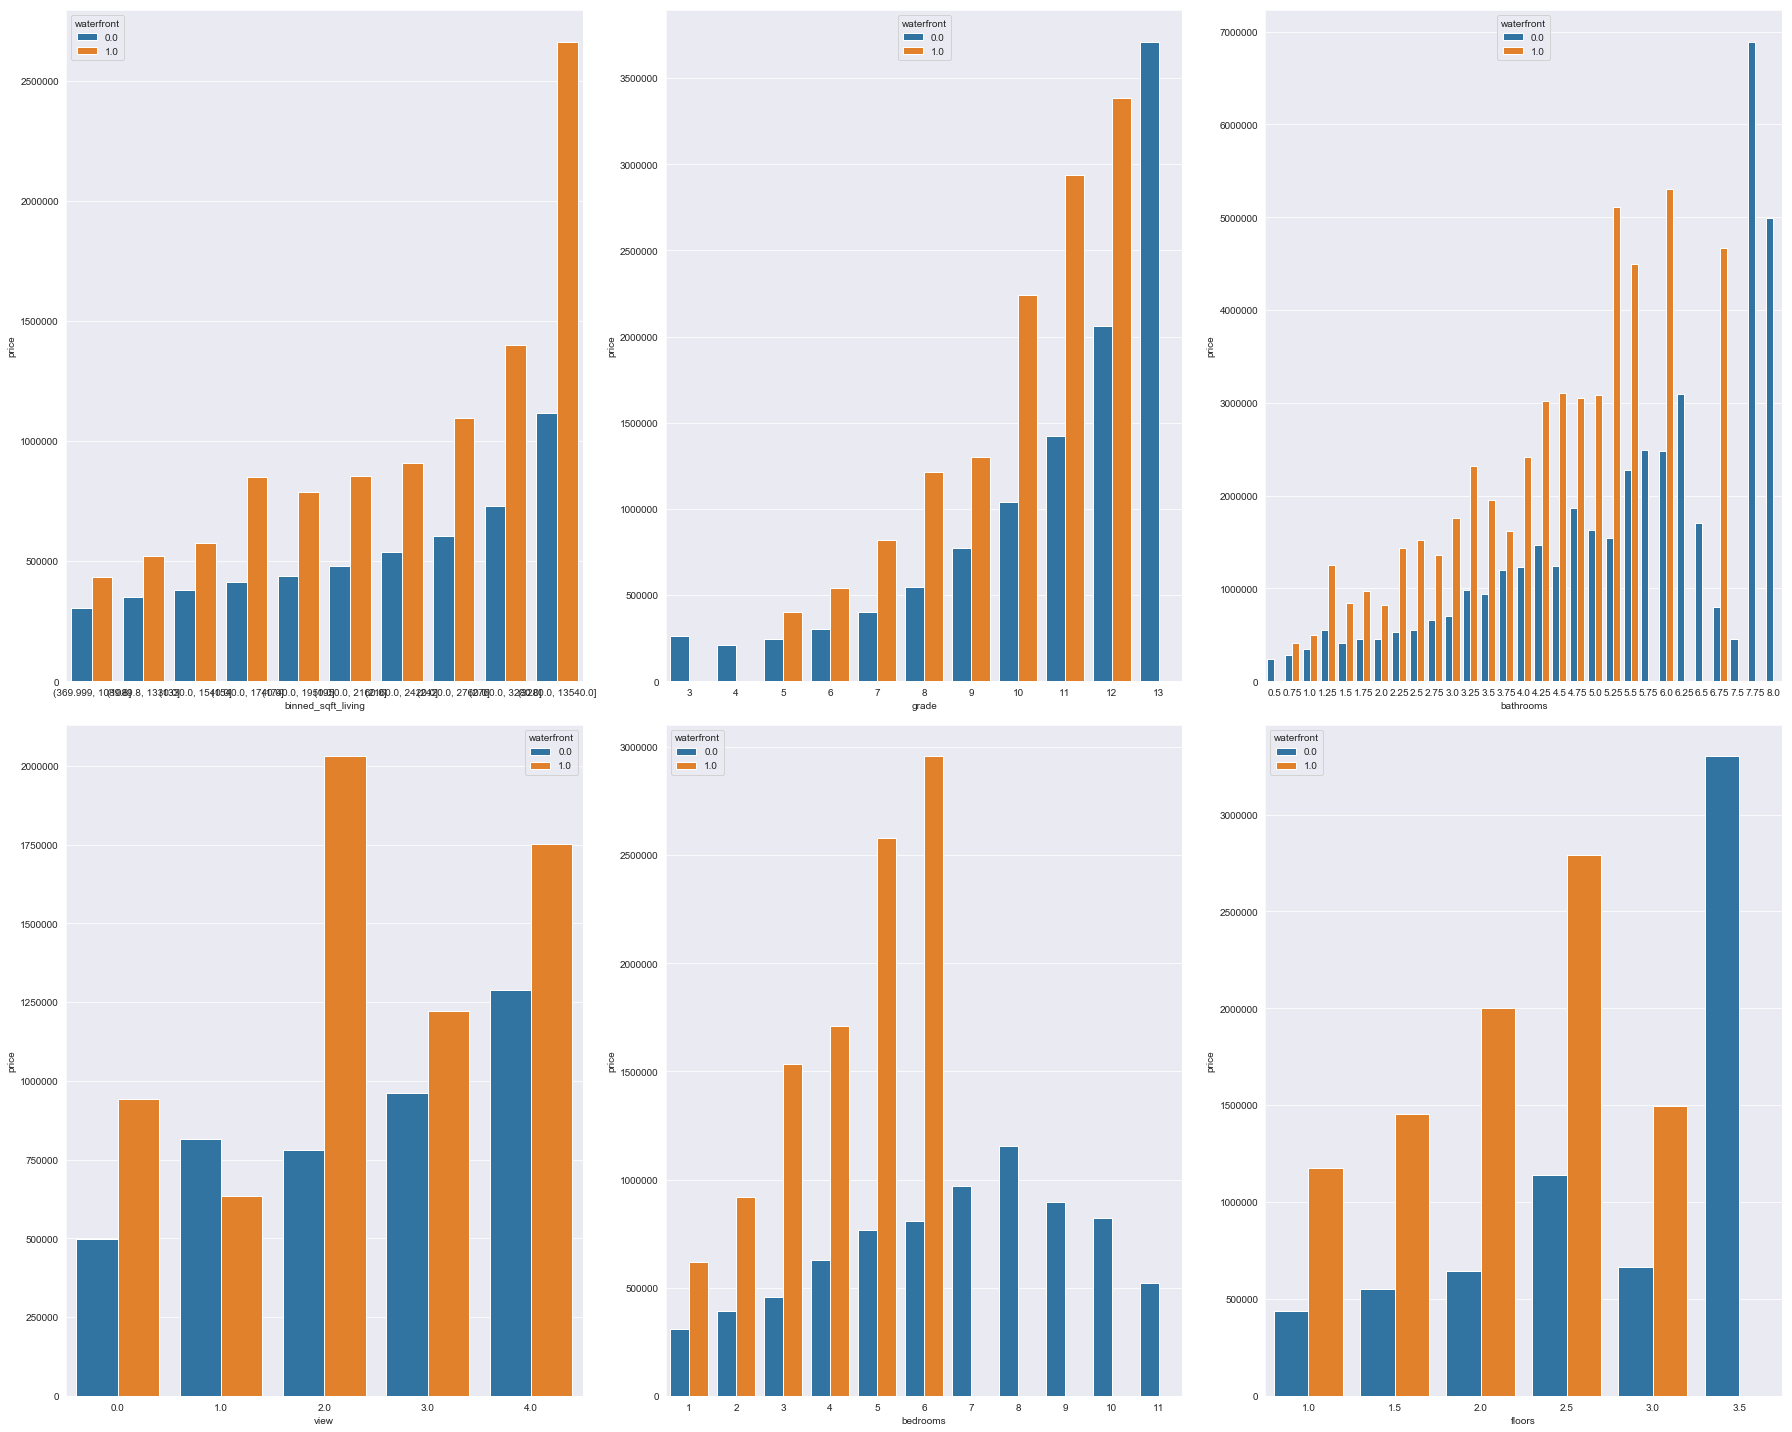

In [29]:
fig, axes = plt.subplots(2, 3, tight_layout = True, figsize = (25,20))
ax = [axes[0, 0], axes[0, 1], axes[0, 2], axes[1, 0], axes[1, 1], axes[1, 2]]

for i in range(len(groupby_list)):
    sns.barplot(x = final[i] , y = 'price', data = groupby_list[i], hue = 'waterfront', ax = ax[i])

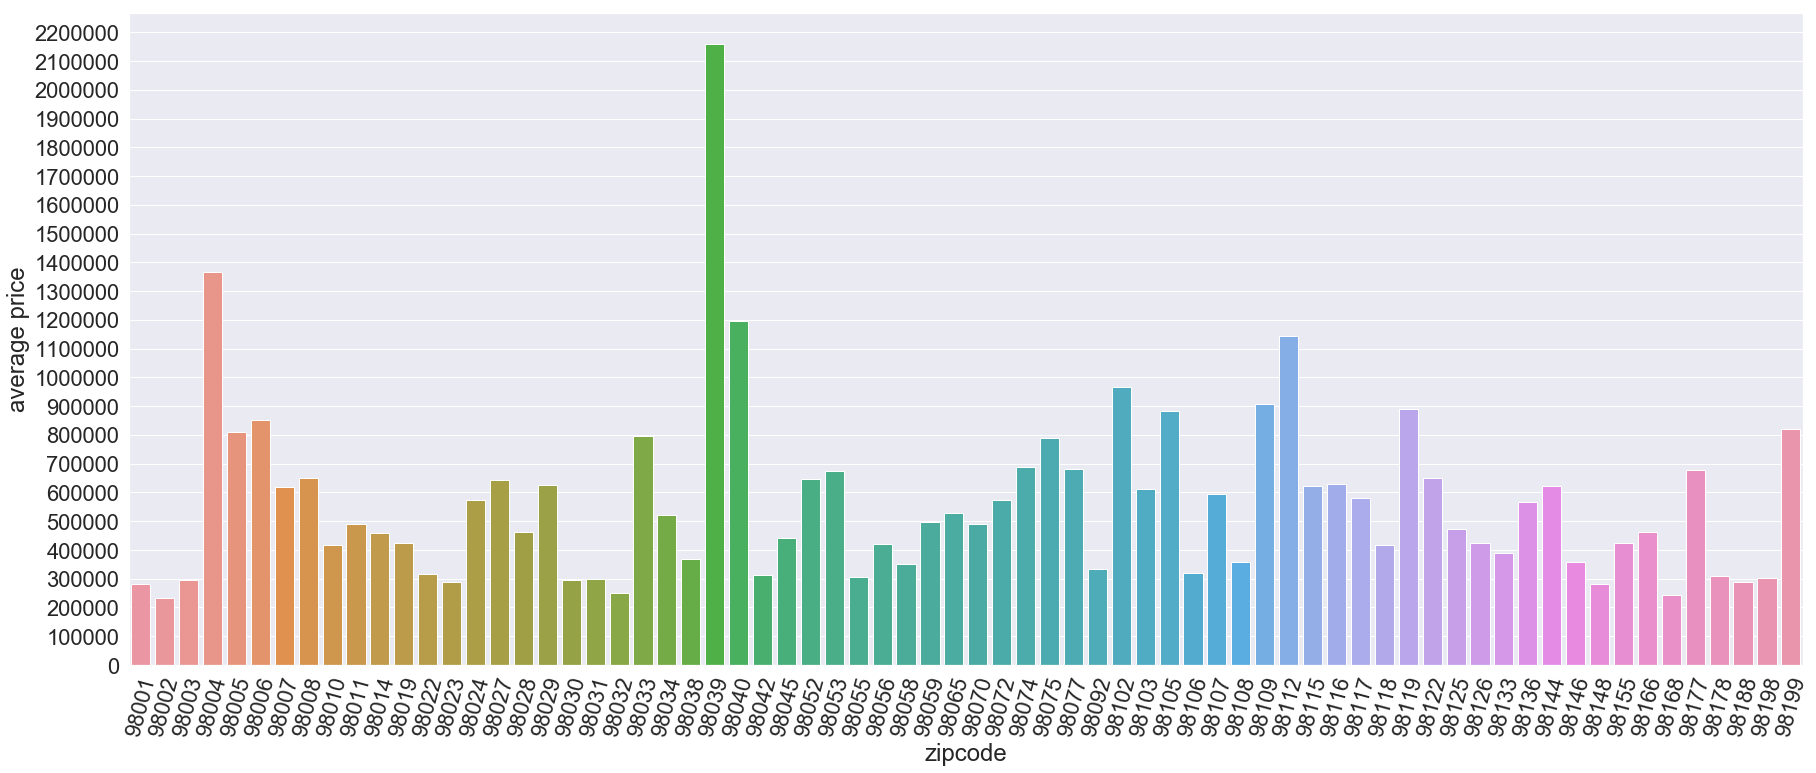

In [30]:
zipcode = df.groupby('zipcode')['price'].mean().reset_index()

sns.set(font_scale = 2)
graph = plt.figure(figsize = (30,12))
graph = sns.barplot(x ='zipcode', y = 'price', data = zipcode)
graph.set_xticklabels(zipcode['zipcode'], rotation =75)
graph.set_ylabel('average price')
graph.yaxis.set_major_locator(ticker.MultipleLocator(100000))
plt.show()

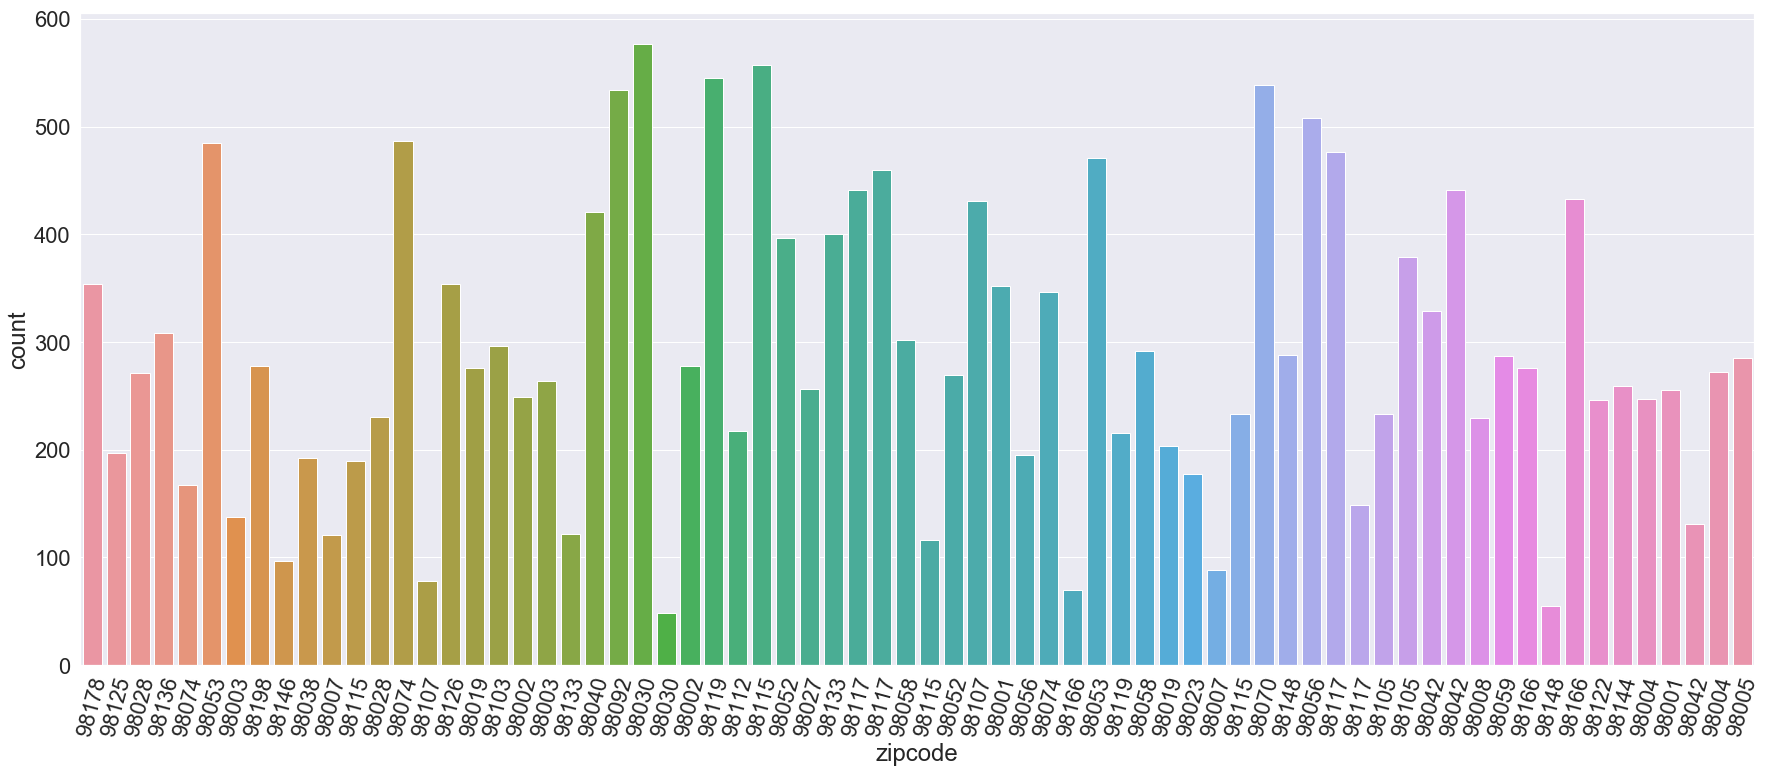

In [31]:
sns.set(font_scale = 2)
ax = plt.figure(figsize = (30,12))
ax = sns.countplot(x = 'zipcode', data = df)
ax.set_xticklabels(df['zipcode'], rotation =75)
plt.show()

## Higher activity in an area, higher the price?

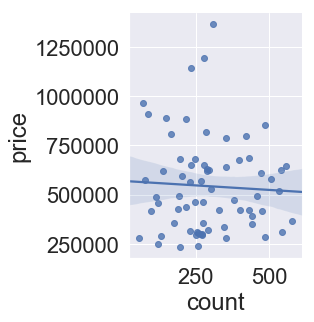

In [32]:
zipcode

x = df.zipcode.value_counts().reset_index()
x.columns = ['zipcode', 'count']

new = pd.merge(zipcode, x, on = 'zipcode')
new = new.drop(new[new.price > 2000000].index, axis = 0)

sns.lmplot(x = 'count', y='price', data =new)
plt.show()

Issue here is that waterfront house does not represent a lot

In [33]:
import folium

coordinates = [df.lat[0], df.long[0]]
x = df.groupby('zipcode')[['lat', 'long', 'price']].mean().sort_values(by = 'price', ascending = False)
y = x.reset_index()
m = folium.Map(
    location = coordinates, 
    zoom_start = 10
)

tooltip = 'Click me!'

for i in y.index:
    folium.Marker([y.lat[i], y.long[i]], 
                  popup = 'Zipcode: {}, Avg Price: {}'.format(y.zipcode[i], int(y.price[i])), 
                  tooltip = tooltip,
                  icon = folium.Icon(icon = 'cloud')).add_to(m)

display(m)

# 3. How have average prices faired over time & when is the best time to sell

In [34]:
df['month_sold'] = df['date'].dt.month 
df['day_sold'] = df['date'].dt.dayofweek

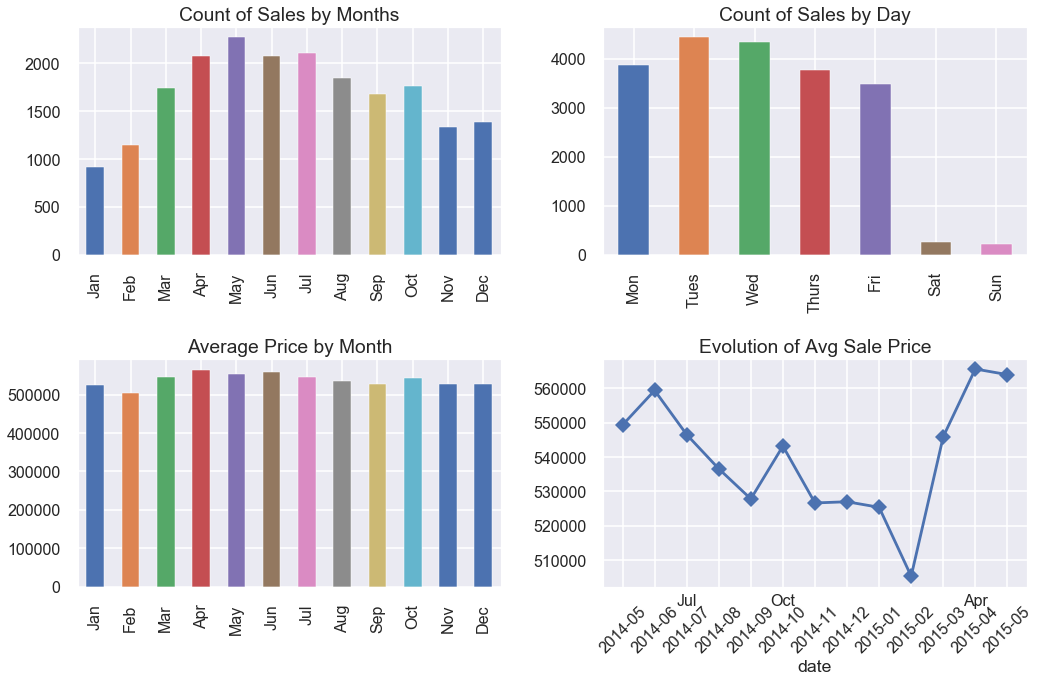

In [35]:
style.use('seaborn-poster')

fig, ax = plt.subplots(2, 2, figsize = (15,10), tight_layout = True)

df.month_sold.value_counts(sort = False).plot(kind = 'bar', ax = ax[0][0], title = 'Count of Sales by Months')
ax[0][0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

df.day_sold.value_counts(sort = False).plot(kind = 'bar', ax = ax[0][1], title = 'Count of Sales by Day')
ax[0][1].set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])

df.groupby('month_sold')['price'].mean().plot(kind = 'bar', ax = ax[1][0], title = 'Average Price by Month')
ax[1][0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[1][0].set_xlabel('')

df.groupby(df.date.dt.to_period('M'))['price'].mean().plot(ax = ax[1][1], title = 'Evolution of Avg Sale Price', marker = 'D')
ax[1][1].set_xticks(df.groupby(df.date.dt.to_period('M'))['price'].mean().index)
plt.xticks(rotation = 45)
ax[1][1].set_xticklabels(df.groupby(df.date.dt.to_period('M'))['price'].mean().index)

plt.show()

Not very useful given the fairly volatile and the short 12m period. 
Tried 12 month rolling price, but still not enough data